<a href="https://colab.research.google.com/github/ghgit1798/2021-financial-competition/blob/Guhyeon/%EC%83%9D%ED%99%9C%EC%84%9C%EB%B9%84%EC%8A%A4%5B%EC%9B%94%EC%84%B8_%EC%84%B8%EA%B8%88%5D_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [ ]:
sh = pd.read_csv('신한카드_업종대분류 전처리완료.csv', index_col=0, encoding='utf-8')

In [ ]:
sh.columns

Index(['기준년월', '광역시도명', '업종대분류', '업종중분류', '업종소분류', '신규가맹점수', '해지가맹점수',
       '매출가맹점수', '카드매출금액', '카드매출건수', '점당매출금액', '건당매출금액'],
      dtype='object')

In [ ]:
sh['업종대분류'].unique()

array(['문화레져', '생활서비스', '음식', '일반유통', '전문서비스', '종합유통', '기타'], dtype=object)

### 카테고리 재분류 필요성
- 따라서 **데이터의 카테고리 재분류가 필요**할 수 있다.
- 개인교통: 교통관련 카테고리인 연료, 자동차정비, 자동차-기타, 수리점
- 일반교통: 대중교통, 택시, 터널/유료도로/하이패스
- 특수교통: 항공, 철도, 화물운송업, 여객선
- 월납/세금: 월납/세금
- 그 외 서비스: 사회단체, 세탁소, 사진, 농기구, 기계/장비 대여, 열쇠/도장 등

In [ ]:
sh = sh[sh['업종대분류'].str.contains('생활서비스')]

In [ ]:
sh['업종중분류'].unique()

array(['기계/장비 대여', '농기구', '대중교통', '미용/사우나/마사지', '사진', '사회단체', '세탁소',
       '수리점', '여객선', '연료', '열쇠/도장', '월납/세금', '자동차-기타', '자동차정비', '철도',
       '택시', '항공', '화물운송업', '터널/유료도로/하이패스'], dtype=object)

In [ ]:
personal_transport = sh[sh['업종중분류'].str.contains('연료|자동차-기타|자동차정비|수리점')]
public_transport = sh[sh['업종중분류'].str.contains('대중교통|택시|터널/유료도로|하이패스')]
special_transport = sh[sh['업종중분류'].str.contains('항공|철도|화물운송업|여객선')]
etc = sh[sh['업종중분류'].str.contains('사회단체|세탁소|사진|농기구|기계/장비 대여|열쇠/도장')]
tax = sh[sh['업종중분류'].str.contains('월납/세금')]

In [ ]:
sh = tax

In [ ]:
sh['업종소분류'].unique()

array(['월납/세금', '통신요금'], dtype=object)

In [ ]:
sh

,기준년월,광역시도명,업종대분류,업종중분류,업종소분류,신규가맹점수,해지가맹점수,매출가맹점수,카드매출금액,카드매출건수,점당매출금액,건당매출금액
98,201903,강원,생활서비스,월납/세금,월납/세금,0,0,23,1620425000,14917,70453273,108629
99,201903,강원,생활서비스,월납/세금,통신요금,0,0,0,0,0,0,0
437,201903,경기,생활서비스,월납/세금,월납/세금,1,0,123,871581000,30011,7086028,29042
438,201903,경기,생활서비스,월납/세금,통신요금,0,0,18,141988620000,2360421,7888256656,60154
783,201903,경남,생활서비스,월납/세금,월납/세금,0,0,77,100556000,3177,1305925,31651
...,...,...,...,...,...,...,...,...,...,...,...,...
22988,202009,제주,생활서비스,월납/세금,통신요금,0,0,0,0,0,0,0
23316,202009,충남,생활서비스,월납/세금,월납/세금,0,0,20,902149000,53936,45107464,16726
23317,202009,충남,생활서비스,월납/세금,통신요금,0,0,0,0,0,0,0
23653,202009,충북,생활서비스,월납/세금,월납/세금,2,0,10,670085000,40038,67008523,16736


In [ ]:
group = sh.groupby(by='업종소분류').sum().reset_index()
group.drop(columns='기준년월', inplace=True)
group

,업종소분류,신규가맹점수,해지가맹점수,매출가맹점수,카드매출금액,카드매출건수,점당매출금액,건당매출금액
0,월납/세금,3,4,2228,5386542831000,18844373,48442433886,6801638
1,통신요금,0,0,268,1554873032000,22091118,54075125853,6840384


In [ ]:
group = group[group['매출가맹점수']!=0]
group = group[group['카드매출건수']!=0]

In [ ]:
# 점당매출금액, 건당매출금액 재계산
group['점당매출금액'] = group['카드매출금액']//group['매출가맹점수']
group['건당매출금액'] = group['카드매출금액']//group['카드매출건수']

In [ ]:
vcols = ['매출가맹점수', '카드매출금액', '카드매출건수', '점당매출금액', '건당매출금액']

In [ ]:
# 표준화 수행
cls = group[vcols]
cols = cls.columns
scaler = StandardScaler()
scaler.fit(cls)
scaled = scaler.transform(cls)
scaled

array([[ 1.,  1., -1., -1.,  1.],
       [-1., -1.,  1.,  1., -1.]])

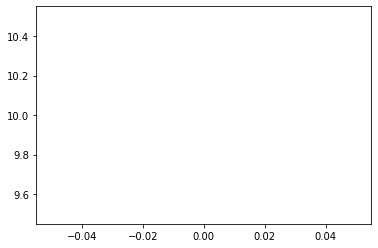

In [ ]:
# screeplot 그리기
def elbow(x):
  sse = []

  for i in range(1, 2):
    km = KMeans(n_clusters=i)
    km.fit(x)
    sse.append(km.inertia_)
    plt.plot(sse)
  plt.show()

elbow(scaled)

In [ ]:
# cluster 수는 2개로 결정
km = KMeans(n_clusters=3)
km.fit(scaled)
km.cluster_centers_

ValueError: ignored

In [ ]:
cluster = pd.DataFrame(km.cluster_centers_, columns=cls.columns)
cluster

In [ ]:
predict = pd.DataFrame(km.predict(scaled))
predict.columns = ['클러스터']
predict

In [ ]:
scaled = pd.DataFrame(data=scaled, columns=cls.columns)
scaled

In [ ]:
names = pd.DataFrame(group['업종소분류'])
names.reset_index(inplace=True, drop=True)
names

In [ ]:
# names와 결합
result = pd.concat([scaled, names], axis=1)
result = pd.concat([result, predict], axis=1)
result

In [ ]:
# cluster labeling
# 0번 클러스터는 가맹점수, 매출건수가 크지만 건당,점당매출은 작은 편의점 같은 산업들이 해당된다.
# 1번 클러스터는 가맹점수, 매출건수는 작지만 건당,점당매출이 큰 유통, 전문서비스 등 음식을 제외한 산업이 해당된다.
cluster

In [ ]:
def show_cluster(result, name):
  categories = cols
  color = ['skyblue', 'blue', 'salmon', 'green', 'orange']

  target = result[result['업종소분류']==name]

  fig = go.Figure()

  fig.add_trace(go.Scatterpolar(
      r = cluster.values[0],
      theta = categories,
      fill='toself',
      name='Cluster0',
      line_color=color[0]
  ))

  fig.add_trace(go.Scatterpolar(
      r = cluster.values[1],
      theta = categories,
      fill='toself',
      name='Cluster1',
      line_color=color[1]
  ))

  fig.add_trace(go.Scatterpolar(
      r = cluster.values[2],
      theta = categories,
      fill='toself',
      name='Cluster2',
      line_color=color[2]
  ))

  fig.add_trace(go.Scatterpolar(
      r = target.values[0],
      theta = categories,
      fill='toself',
      name=name,
      line_color=color[3]
  ))

  # fig.add_trace(go.Scatterpolar(
  #     r = cluster.values[3],
  #     theta = categories,
  #     fill='toself',
  #     name='Cluster3',
  #     line_color=color[3]
  # ))

  # fig.add_trace(go.Scatterpolar(
  #     r = target.values[0],
  #     theta = categories,
  #     fill='toself',
  #     name=name,
  #     line_color=color[4]
  # ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        title=str(target['클러스터']),
        visible=True,
      )),
  )
  print(name, target['클러스터'])
  fig.show()

# 클라우드 맥주 클러스터링 결과
# show_cluster(result, '편의점')

In [ ]:
# StandardScaler, MinMaxScaler 사용 시 Outlier에 굉장히 민감함.
for col in sh['업종소분류'].unique():
  show_cluster(result, col)

### 결과
1. 여객선, 콜백, 퀵배달 은 공통된 특징을 갖고 같은 클러스터로 분류됨
2. 철도/항공사/종합이삿짐대행 서비스는 각각 개별분류
3. 택배업과 화물운송 분류는 유사한 특징을 갖고 같은 클러스터로 분류됨